In [70]:
import numpy as np
from tqdm import tqdm
from numba import njit

from multiprocessing import Pool

In [155]:
@njit
def spherical_func(X, X0=None):
    if X0 is None:
        X0 = np.zeros(X.shape[0])
    return np.sum(np.power(X - X0, 2))


@njit
def rastrigin_func(X):
    return np.sum(np.power(X, 2) - 10*np.cos(2*np.pi*X) + 10) - 330


#@njit
def rosenbrok_func(X):
    s = 0
    for i in range(X.shape[0] - 1):
        s += 100 * (X[i]**2 - X[i+1])**2 + (X[i] - 1)**2
    return s - 390

spherical_func(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

0.08000000000000002

In [132]:
# Матрица попарных расстояний
@njit
def calc_dist(X):
    dist = np.zeros((X.shape[0], X.shape[0]))
    for i in range(1, X.shape[0]):
        for j in range(i):
            dist[i, j] = np.linalg.norm(X[i]-X[j])
            dist[j, i] = dist[i, j]
    return dist

# Построить NNNS для Xi
def MNNS(X, FX, i):
    dist = calc_dist(X)
    sequence = [(i, X[i], FX[i])]
    while True:
        candidates = np.argwhere(FX < sequence[-1][2])
        if len(candidates) == 0:
            break
        min_dist = dist[sequence[-1][0], candidates].min()
        h = np.argwhere(dist[sequence[-1][0]] == min_dist)[0, 0]
        sequence.append((h, X[h], FX[h]))
    return sequence


# Стратегии поиска, входящие в SP
def ss1(X, FX, i):
    MSi = np.array(np.array([j[1] for j in MNNS(X, FX, i)]))
    MCXi = np.mean(MSi, axis=0)
    best = np.argwhere(FX == np.min(FX))[0, 0]
    k = np.random.randint(X.shape[0] - 1)
    if k >= i:
        k += 1
    Vi = X[i].copy()
    j = np.random.randint(X.shape[1])
    Vi[j] = MCXi[j] + np.random.uniform(-1., 1.)*(X[best, j] - X[k, j])
    return Vi

def ss2(X, FX, i):
    MSi = np.array(np.array([j[1] for j in MNNS(X, FX, i)]))
    best = np.argwhere(FX == np.min(FX))[0, 0]
    Vi = X[i].copy()
    j = np.random.randint(X.shape[1])
    if MSi.shape[0] == 1:
        k = np.random.randint(X.shape[0] - 1)
        if k >= i:
            k += 1
        Vi[j] = X[best, j] + np.random.uniform(-1., 1.)*(X[best, j] - X[k, j])
    else:
        h = np.random.randint(MSi.shape[0] - 1)
        Vi[j] = X[best, j] + np.random.uniform(-1., 1.)*(MSi[h+1, j] - MSi[h, j])
    return Vi

In [193]:
def initialize_X(SN, Xmin, Xmax, SP, func):
    if Xmin.shape != Xmax.shape:
        raise ValueError('initialize_X: Xmin.shape != Xmax.shape')
    X = np.zeros((SN, Xmin.shape[0]))
    FX = np.zeros(SN)
    for i in range(SN):
        X[i] = Xmin + np.random.uniform(0, 1, Xmin.shape[0])*(Xmax - Xmin)
        FX[i] = func(X[i])
    SP_idx = np.random.randint(len(SP), size=X.shape[0])
    return X, FX, SP_idx


def employed_phase(X, FX, SP, SP_idx, trial, func):
    V = np.zeros(X.shape)
    FV = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        V[i] = SP[SP_idx[i]](X, FX, i)
        FV[i] = func(V[i])
    for i in range(X.shape[0]):
        if FV[i] < FX[i]:
            X[i] = V[i]
            FX[i] = FV[i]
            trial[i] = 0
            # Обновляем стратегию поиска
            SP_idx_candidate = np.random.randint(len(SP) - 1)
            if SP_idx_candidate == SP_idx[i]:
                SP_idx[i] = SP_idx_candidate + 1
            else:
                SP_idx[i] = SP_idx_candidate
        else:
            trial[i] += 1
    return X, FX, SP_idx, trial


def onlooker_phase(X, FX, SP, SP_idx, trial, func):
    V = np.zeros(X.shape)
    FV = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        MSi = np.array(np.array([j[1] for j in MNNS(X, FX, i)]))
        r = np.random.randint(MSi.shape[0]-1) + 1 if MSi.shape[0] > 1 else 0
        h = np.argwhere(FX == func(MSi[r]))[0, 0]
        V[h] = SP[SP_idx[h]](X, FX, h)
        FV[h] = func(V[h])
    for i in range(X.shape[0]):
        if FV[i] == 0:
            continue
        if FV[i] < FX[i]:
            X[i] = V[i]
            FX[i] = FV[i]
            trial[i] = 0
            # Обновляем стратегию поиска
            SP_idx_candidate = np.random.randint(len(SP) - 1)
            if SP_idx_candidate == SP_idx[i]:
                SP_idx[i] = SP_idx_candidate + 1
            else:
                SP_idx[i] = SP_idx_candidate
        else:
            trial[i] += 1
    return X, FX, SP_idx, trial

def onlooker_old_phase(X, FX, SP, SP_idx, trial, func):
    def fit(f):
        return 1./(1+f) if f >= 0 else 1 + np.abs(f)
    
    fitX = np.vectorize(fit)(FX)
    idx_selected = np.random.choice(
        X.shape[0],
        p=fitX/np.sum(fitX)
    )
    X_selected = X[idx_selected].copy()
    
    V = np.zeros(X.shape)
    FV = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        k = np.random.randint(X.shape[0] - 1)
        if k >= i:
            k += 1
        V[i] = X[i] + np.random.uniform(-1., 1.)*(X[i] - X_selected)
        FV[i] = func(V[i])
    for i in range(X.shape[0]):
        if FV[i] < FX[i]:
            X[i] = V[i]
            FX[i] = FV[i]
            trial[i] = 0
        else:
            trial[i] += 1            
    return X, FX, SP_idx, trial


def scout_phase(X, FX, SP, SP_idx, trial, func, Xmin, Xmax, trial_lim):
    for i in range(X.shape[0]):
        if trial[i] >= trial_lim:
            XX, FXX, SP_idxXX = initialize_X(1, Xmin, Xmax, SP, func)
            X[i] = XX[0]
            FX[i] = FXX[0]
            SP_idx[i] = SP_idxXX[0]
            trial[i] = 0
    return X, FX, SP_idx, trial


def form_data(iteration, phase, X, FX, SP_idx, trial):
    return {
        'iteration': iteration,
        'phase': 'initialize',
        'X': X.copy(),
        'FX': FX.copy(),
        'SP_idx': SP_idx.copy(),
        'trial': trial.copy()
    }

def NNSABC(SN, Xmin, Xmax, SP, func, max_iterations=1000, trial_lim=30, stagnation_lim=20, stagnation_eps=1e-6):
    path = []
    stagnation_cnt = 0
    stop_reason = 'max_iterations'
    X, FX, SP_idx = initialize_X(SN, Xmin, Xmax, SP, func)
    trial = np.zeros(X.shape[0])
    path.append(form_data(0, 'initialize', X, FX, SP_idx, trial))
    X_best_prev = X[np.argwhere(FX == np.min(FX))[0, 0]]
    for iteration in tqdm(range(max_iterations)):
        X_best_curr = X[np.argwhere(FX == np.min(FX))[0, 0]]
        if np.abs(func(X_best_curr) - func(X_best_prev)) < stagnation_eps:
            stagnation_cnt += 1
            if stagnation_cnt >= stagnation_lim:
                stop_reason = 'stagnation_lim'
                break
        else:
            stagnation_cnt = 0
        X_best_prev = X_best_curr
        X, FX, SP_idx, trial = employed_phase(X, FX, SP, SP_idx, trial, func)
        path.append(form_data(iteration, 'employed', X, FX, SP_idx, trial))
        #X, FX, SP_idx, trial = onlooker_phase(X, FX, SP, SP_idx, trial, func)
        X, FX, SP_idx, trial = onlooker_old_phase(X, FX, SP, SP_idx, trial, func)
        path.append(form_data(iteration, 'onlooker', X, FX, SP_idx, trial))
        X, FX, SP_idx, trial = scout_phase(X, FX, SP, SP_idx, trial, func, Xmin, Xmax, trial_lim=10)
    return stop_reason, X_best_curr, X, FX, path

#func = spherical_func
func = rastrigin_func
#func = rosenbrok_func

dimensions = 8
alpha = 2
#alpha = 100
Xmin = np.array([- alpha] * dimensions)
Xmax = np.array([alpha] * dimensions)
SN = 80
SP = [ss1, ss2]
max_iterations = 200

stop_reason, X_best,  X,FX, path = NNSABC(SN, Xmin, Xmax, SP, func, max_iterations)
FX_best = func(X_best)
print(stop_reason)
print(FX_best)
print(X_best)

 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:12<00:04, 12.19it/s]

stagnation_lim
-329.9999999768229
[-3.65472260e-06 -4.41394510e-06 -1.96433507e-07  2.25253335e-06
  2.26855344e-06 -3.02218543e-06  1.70336004e-06 -7.85435984e-06]


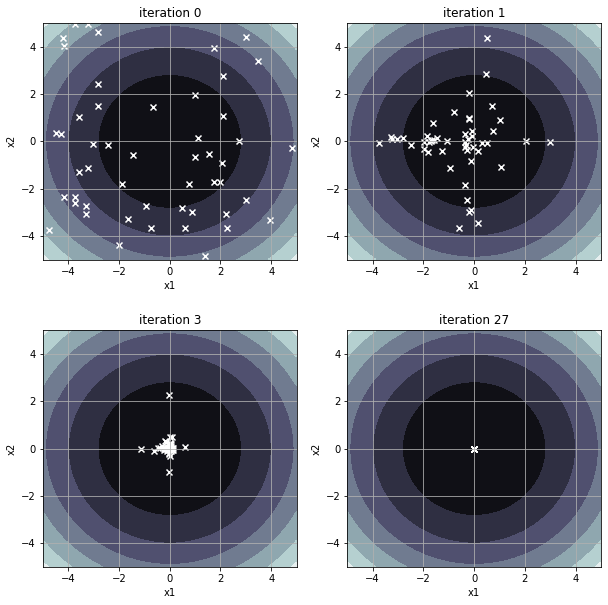

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_X(fig, subplot_i, X, Xmin, Xmax, title, func=None):
    if X.shape[1] != 2:
        return
    #fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(subplot_i)
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_xlim([Xmin[0], Xmax[0]])
    ax1.set_ylim([Xmin[1], Xmax[1]])
    if func:
        size = 100
        XX, YY = np.meshgrid(np.linspace(Xmin[0], Xmax[0], size), np.linspace(Xmin[1], Xmax[1], size))
        Z = np.zeros((size, size))
        for i, x in enumerate(np.linspace(Xmin[0], Xmax[0], size)):
            for j, y in enumerate(np.linspace(Xmin[1], Xmax[1], size)):
                Z[j, i] = func(np.array([x, y]))
        ax1.contourf(XX, YY, Z, cmap=plt.cm.bone)
    ax1.scatter(
        X[:, 0],
        X[:, 1],
        c='white',
        marker='x'
    )
    ax1.set_title(title)
    ax1.grid()
    #plt.legend(loc='upper left')
    #plt.show()

fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
plot_X(fig, 221, path[0]['X'], Xmin, Xmax, f"iteration {path[0]['iteration']}", func)
plot_X(fig, 222, path[3]['X'], Xmin, Xmax, f"iteration {path[4]['iteration']}", func)
plot_X(fig, 223, path[9]['X'], Xmin, Xmax, f"iteration {path[8]['iteration']}", func)
plot_X(fig, 224, path[-1]['X'], Xmin, Xmax, f"iteration {path[-1]['iteration']}", func)
plt.show()

In [137]:
# Тестируем Растригина

dimensions_list = [2, 4, 8, 16, 32]
dimensions_list = [16, 32]

func = rastrigin_func
alpha = 5
SN = 80
SP = [ss1, ss2]
max_iterations = 1000

res = []

for dimensions in dimensions_list:
    Xmin = np.array([- alpha] * dimensions)
    Xmax = np.array([alpha] * dimensions)
    for start in range(10):
        print('dimensions:', dimensions)
        print('start num: ', start)
        print('Xmin:      ')
        print(Xmin)
        print('Xmax:      ')
        print(Xmax)
        stop_reason, X_best,  X,FX, path = NNSABC(SN, Xmin, Xmax, SP, func, max_iterations)
        FX_best = func(X_best)
        print('stop_reason', stop_reason)
        print('FX_best', FX_best)
        res.append({
            'start_num': start,
            'stop_reason': stop_reason,
            'FX_best': FX_best,
            'X_best': X_best,
            'path': path
        })

dimensions: 16
start num:  0
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 35%|███████████████████████████▍                                                   | 348/1000 [00:30<00:56, 11.58it/s]


stop_reason stagnation_lim
FX_best -328.0100695033514
dimensions: 16
start num:  1
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 38%|██████████████████████████████                                                 | 381/1000 [00:33<00:53, 11.52it/s]


stop_reason stagnation_lim
FX_best -326.02016190773867
dimensions: 16
start num:  2
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 33%|█████████████████████████▊                                                     | 326/1000 [00:28<00:58, 11.58it/s]


stop_reason stagnation_lim
FX_best -328.010073165095
dimensions: 16
start num:  3
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 35%|███████████████████████████▍                                                   | 347/1000 [00:29<00:56, 11.61it/s]


stop_reason stagnation_lim
FX_best -328.01007906335974
dimensions: 16
start num:  4
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 18%|██████████████                                                                 | 178/1000 [00:15<01:09, 11.82it/s]


KeyboardInterrupt: 

In [126]:
import pandas as pd

rastrigin_df = pd.DataFrame([{
    'start_num': i['start_num'],
    'stop_reason': i['stop_reason'],
    'FX_best': i['FX_best'],
    'X_best': i['X_best']
} for i in res])
rastrigin_df['dimensions'] = rastrigin_df['X_best'].apply(lambda x: np.shape(x)[0])
rastrigin_df['error_norm'] = (rastrigin_df['FX_best'] + 330.).apply(np.abs)
rastrigin_df

,start_num,stop_reason,FX_best,X_best,dimensions,error_norm
0,0,stagnation_lim,-330.000000,"[-8.625870704678567e-09, -7.214367672586988e-09]",2,0.000000
1,1,stagnation_lim,-329.005041,"[0.9949586292227688, -4.549071983283015e-09]",2,0.994959
2,2,stagnation_lim,-330.000000,"[-6.3419352475378786e-09, 3.918396633322755e-09]",2,0.000000
3,3,stagnation_lim,-330.000000,"[8.746436255189846e-09, -6.724434809873954e-09]",2,0.000000
4,4,stagnation_lim,-330.000000,"[6.805784409782695e-09, -9.129537086042051e-09]",2,0.000000
...,...,...,...,...,...,...
95,15,stagnation_lim,-107.128251,"[-1.0923336897532563, 1.122916536640351, -3.55...",32,222.871749
96,16,stagnation_lim,-168.524348,"[-1.0862663569995663, 1.1424245908350588, -0.0...",32,161.475652
97,17,stagnation_lim,-101.137219,"[0.7955205107128559, -1.3709411730599739, -1.9...",32,228.862781
98,18,stagnation_lim,-100.993178,"[0.9886856005029471, 2.1266564731010966, -0.00...",32,229.006822


In [127]:
# Считаем вероятность попадания в глобальный минимум
global_prob = []
for dimensions in rastrigin_df['dimensions'].unique():
    global_prob.append({
        'dimensions': dimensions,
        'global_prob': float(np.sum((rastrigin_df['dimensions'] == dimensions) & (rastrigin_df['error_norm'] <= 1e-2))) / \
                       float(np.sum(rastrigin_df['dimensions'] == dimensions))
    })
global_prob_df = pd.DataFrame(global_prob)
global_prob_df

,dimensions,global_prob
0,2,0.95
1,4,0.00
2,8,0.00
3,16,0.00
4,32,0.00


In [139]:
# Тестируем Розенброка

#dimensions_list = [2, 4, 8, 16, 32]
dimensions_list = [2, 4]

func = rosenbrok_func
alpha = 100
SN = 80
SP = [ss1, ss2]
max_iterations = 1000

res_ros = []

for dimesions in dimensions_list:
    Xmin = np.array([- alpha] * dimensions)
    Xmax = np.array([alpha] * dimensions)
    for start in range(20):
        print(start)
        stop_reason, X_best,  X,FX, path = NNSABC(SN, Xmin, Xmax, SP, func, max_iterations)
        FX_best = func(X_best)
        print('stop_reason', stop_reason)
        print('FX_best', FX_best)
        res_ros.append({
            'start_num': start,
            'stop_reason': stop_reason,
            'FX_best': FX_best,
            'X_best': X_best,
            'path': path
        })

0


 55%|███████████████████████████████████████████                                    | 545/1000 [00:49<00:41, 10.91it/s]


stop_reason stagnation_lim
FX_best -319.1213906195929
1


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [01:02<00:29, 10.79it/s]


stop_reason stagnation_lim
FX_best -290.5011744163496
2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.83it/s]


stop_reason max_iterations
FX_best -375.2078294597471
3


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [01:04<00:27, 10.88it/s]


stop_reason stagnation_lim
FX_best -243.3075974844346
4


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [01:06<00:25, 10.87it/s]


stop_reason stagnation_lim
FX_best -242.19376796620105
5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.87it/s]


stop_reason max_iterations
FX_best -385.84399306785747
6


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.85it/s]


stop_reason max_iterations
FX_best -381.4336535654001
7


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:50<00:41, 10.90it/s]


stop_reason stagnation_lim
FX_best -82.82375961252518
8


 43%|█████████████████████████████████▉                                             | 429/1000 [00:39<00:52, 10.95it/s]


stop_reason stagnation_lim
FX_best -325.0241619278798
9


 45%|███████████████████████████████████▋                                           | 452/1000 [00:41<00:50, 10.88it/s]


stop_reason stagnation_lim
FX_best -349.4630909321414
10


 46%|████████████████████████████████████▎                                          | 459/1000 [00:41<00:49, 10.94it/s]


stop_reason stagnation_lim
FX_best 1644.729110603996
11


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.90it/s]


stop_reason max_iterations
FX_best -387.7038107031439
12


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [01:01<00:29, 10.90it/s]


stop_reason stagnation_lim
FX_best -380.42148137247233
13


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.88it/s]


stop_reason max_iterations
FX_best -207.51538841745906
14


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.82it/s]


stop_reason max_iterations
FX_best -388.1120174115134
15


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [01:21<00:10, 10.85it/s]


stop_reason stagnation_lim
FX_best 448.24801025237275
16


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.79it/s]


stop_reason max_iterations
FX_best -389.93775204024
17


 47%|████████████████████████████████████▊                                          | 466/1000 [00:42<00:49, 10.86it/s]


stop_reason stagnation_lim
FX_best -285.53713516307187
18


 59%|██████████████████████████████████████████████▎                                | 586/1000 [00:54<00:38, 10.83it/s]


stop_reason stagnation_lim
FX_best 2990.0434696819743
19


 36%|████████████████████████████▎                                                  | 359/1000 [00:32<00:58, 10.95it/s]


stop_reason stagnation_lim
FX_best 5428.682076628319
0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.91it/s]


stop_reason max_iterations
FX_best -389.3805395505341
1


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [01:00<00:32, 10.82it/s]


stop_reason stagnation_lim
FX_best -298.2130516741513
2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.79it/s]


stop_reason max_iterations
FX_best -302.40199874185
3


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.78it/s]


stop_reason max_iterations
FX_best -389.84132582147646
4


 37%|█████████████████████████████▌                                                 | 374/1000 [00:34<00:57, 10.91it/s]


stop_reason stagnation_lim
FX_best 206.31063649048133
5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.85it/s]


stop_reason max_iterations
FX_best -331.8542091774766
6


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [01:22<00:10, 10.74it/s]


stop_reason stagnation_lim
FX_best -379.9432503239524
7


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.84it/s]


stop_reason max_iterations
FX_best -323.377580195391
8


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [01:23<00:08, 10.88it/s]


stop_reason stagnation_lim
FX_best -357.20143680080133
9


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.93it/s]


stop_reason max_iterations
FX_best -385.6801389659802
10


 24%|███████████████████▏                                                           | 243/1000 [00:22<01:08, 11.00it/s]


stop_reason stagnation_lim
FX_best 259.6340925218717
11


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [01:24<00:07, 10.83it/s]


stop_reason stagnation_lim
FX_best -381.23838621800894
12


 36%|████████████████████████████                                                   | 356/1000 [00:32<00:58, 10.99it/s]


stop_reason stagnation_lim
FX_best 322.1711203138942
13


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.86it/s]


stop_reason max_iterations
FX_best -379.4027123090582
14


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:43<00:48, 10.85it/s]


stop_reason stagnation_lim
FX_best -229.9799506592003
15


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [00:53<00:38, 10.90it/s]


stop_reason stagnation_lim
FX_best 243.50849751818816
16


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [00:56<00:34, 10.96it/s]


stop_reason stagnation_lim
FX_best -270.4915613273598
17


 49%|██████████████████████████████████████▍                                        | 486/1000 [00:44<00:47, 10.92it/s]


stop_reason stagnation_lim
FX_best 308.0016923883112
18


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.90it/s]


stop_reason max_iterations
FX_best -389.84943031848604
19


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:46<00:44, 10.90it/s]

stop_reason stagnation_lim
FX_best -127.12923025502266
